<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Settings,-Setup-and-Libraries" data-toc-modified-id="Settings,-Setup-and-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Settings, Setup and Libraries</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Find-success-rate" data-toc-modified-id="Find-success-rate-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Find success rate</a></span></li><li><span><a href="#Find-the-length" data-toc-modified-id="Find-the-length-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Find the length</a></span></li><li><span><a href="#Find-root" data-toc-modified-id="Find-root-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>Find root</a></span></li><li><span><a href="#Function-from-parameters-to-p50" data-toc-modified-id="Function-from-parameters-to-p50-1.2.0.4"><span class="toc-item-num">1.2.0.4&nbsp;&nbsp;</span>Function from parameters to p50</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Finding-the-p50-probability-calculations" data-toc-modified-id="Finding-the-p50-probability-calculations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Finding the p50 probability calculations</a></span><ul class="toc-item"><li><span><a href="#Doing-the-calculations-for-examples" data-toc-modified-id="Doing-the-calculations-for-examples-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Doing the calculations for examples</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Example" data-toc-modified-id="Example-2.1.0.1"><span class="toc-item-num">2.1.0.1&nbsp;&nbsp;</span>Example</a></span></li><li><span><a href="#A-full-example-with-both-length-and-root-finding" data-toc-modified-id="A-full-example-with-both-length-and-root-finding-2.1.0.2"><span class="toc-item-num">2.1.0.2&nbsp;&nbsp;</span>A full example with both length and root finding</a></span></li><li><span><a href="#Bootstrap-variability-of-success-rate-depending-on-the-number-of-samples" data-toc-modified-id="Bootstrap-variability-of-success-rate-depending-on-the-number-of-samples-2.1.0.3"><span class="toc-item-num">2.1.0.3&nbsp;&nbsp;</span>Bootstrap variability of success rate depending on the number of samples</a></span></li><li><span><a href="#A-complete-examples-in-one-function" data-toc-modified-id="A-complete-examples-in-one-function-2.1.0.4"><span class="toc-item-num">2.1.0.4&nbsp;&nbsp;</span>A complete examples in one function</a></span></li></ul></li></ul></li><li><span><a href="#Systematic-probability" data-toc-modified-id="Systematic-probability-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Systematic probability</a></span><ul class="toc-item"><li><span><a href="#Alpha" data-toc-modified-id="Alpha-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Alpha</a></span></li><li><span><a href="#Ws" data-toc-modified-id="Ws-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Ws</a></span></li><li><span><a href="#Minicolumns" data-toc-modified-id="Minicolumns-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Minicolumns</a></span></li></ul></li></ul></li></ul></div>

# Preamble

## Settings, Setup and Libraries

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=2.5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, deterministic_solution
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

epsilon = 10e-80
vmin = -10.0

## Functions

#### Find success rate

In [45]:
def find_success_rate(manager, T_recall, n_samples, sigma_out):
    manager.nn.sigma_in = sigma_out * np.sqrt(2 / tau_s) 
    manager.nn.sigma_out = sigma_out
    T_cue = manager.nn.tau_s
    I_cue = 0
    nr = manager.canonical_network_representation
    success_list = []
    for index in range(n_samples):
        aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
        success, pattern_sequence, persistent_times, timings = aux
        success_list.append(success)
        
    return 0.5 - np.mean(success_list)

#### Find the length

In [137]:
def find_right_length(length, manager, n_samples, T_recall):
    found = False
    number = 1.0
    while(not found):
        sigma_out = number * length
        success_rate = find_success_rate(manager, T_recall=T_recall, n_samples=n_samples, sigma_out=sigma_out)
        if success_rate < 0.50:
            found = True
        else:
            number += 1.0
    
    return number

#### Find root

In [136]:
def find_root(number, manager, T_recall, n_samples=50, deep=10, verbose=False):
    left = (number - 1) * length 
    right = number * length
    if verbose:
        print('bounds', left, right)
        
    for i in range(deep):
        sigma_test = (left + right) * 0.5
        result = find_success_rate(manager, T_recall=T_recall, n_samples=n_samples, sigma_out=sigma_test)
        if result > 0.5:
            left = sigma_test
        else:
            right = sigma_test

        if np.abs(sigma_test - 0.5) < 0.01:
            break
        if verbose:
            print('result', result)
            print('bounds', left, right)
            
    return sigma_test, result

#### Function from parameters to p50

In [146]:
def find_p50(ws, wn, wb, alpha, minicolumns, hypercolumns, T_persistence, n_samples=100, deep=15, verbose=False):
    strict_maximum = True

    g_a = 1.0
    g_I = 10.0
    tau_a = 0.250
    G = 1.0
    sigma_out = 0.0
    tau_s = 0.010
    tau_z_pre = 0.025
    tau_z_post = 0.005

    n_patterns = minicolumns

    # Manager properties
    dt = 0.001
    values_to_save = ['o']

    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Protocol
    manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb ,alpha=alpha)

    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    
    # First ffind the half length
    n_samples_length = 30
    T_recall = T_persistence * minicolumns + tau_s
    number = find_right_length(length, manager, n_samples_length, T_recall)
    sigma05, p05 = find_root(number, manager, T_recall, n_samples=n_samples, deep=deep, verbose=verbose)
    
    return sigma05, p05

# Finding the p50 probability calculations

## Doing the calculations for examples

#### Example

In [27]:
strict_maximum = True

g_a = 1.0
g_I = 1.0
tau_a = 0.250
G = 100.0
sigma_out = 0.0
tau_s = 0.010
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training
ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0

T_persistence = 0.080


# Manager properties
dt = 0.001
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
manager.run_artificial_protocol(ws=ws, wn=wn, wb=wb ,alpha=alpha)

manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
T_recall = T_persistence 
T_cue = tau_s
I_cue = 0
nr = manager.canonical_network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=0.009, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

In [94]:
%%time
length = ws - (wn - alpha)
sigma_out =  3 * length 
n_samples = 100
T_recall = T_persistence * manager.nn.minicolumns + tau_s
success_rate = find_success_rate(manager, T_recall=T_recall, n_samples=n_samples, sigma_out=sigma_out)
print(success_rate)

0.49
CPU times: user 3.9 s, sys: 4 ms, total: 3.91 s
Wall time: 3.93 s


In [131]:
%%time
n_samples = 30
number = find_right_length(length, manager, n_samples, T_recall)
print(number)

4.0
CPU times: user 4.7 s, sys: 0 ns, total: 4.7 s
Wall time: 4.74 s


In [135]:
print(length)
print(number * length)

2.0
8.0


An example of the code used to calculate the root, now a function

In [123]:
%%time
n_samples = 50
deep = 15
left = (number - 1) * length 
right = number * length
print(left, right)
# Test for middle
for i in range(deep):
    sigma_test = (left + right) * 0.5
    result = find_success_rate(manager, T_recall=T_recall, n_samples=n_samples, sigma_out=sigma_test)
    if result > 0.5:
        left = sigma_test
    else:
        right = sigma_test
  
    print('result', result)
    print('bounds', left, right)

print('result', result)
print('sigma', sigma_test)

4.0 6.0
5.0 6.0
5.5 6.0
5.75 6.0
5.875 6.0
5.9375 6.0
5.9375 5.96875
5.9375 5.953125
5.9375 5.9453125
5.94140625 5.9453125
5.943359375 5.9453125
5.943359375 5.9443359375
5.94384765625 5.9443359375
5.944091796875 5.9443359375
5.9442138671875 5.9443359375
5.9442138671875 5.94427490234375
result 0.46
sigma 5.94427490234375
CPU times: user 30.1 s, sys: 28 ms, total: 30.1 s
Wall time: 30.2 s


In [138]:
success_rate = find_success_rate(manager, T_recall=T_recall, n_samples=n_samples, sigma_out=sigma_test)
print(success_rate)

0.4666666666666667


In [134]:
%%time
root, result = find_root(number, manager, T_recall, n_samples=100, deep=10, verbose=True)

bounds 6.0 8.0
result 0.3
bounds 6.0 7.0
result 0.34
bounds 6.0 6.5
result 0.52
bounds 6.25 6.5
result 0.45
bounds 6.25 6.375
result 0.37
bounds 6.25 6.3125
result 0.49
bounds 6.25 6.28125
result 0.37
bounds 6.25 6.265625
result 0.5
bounds 6.25 6.2578125
result 0.53
bounds 6.25390625 6.2578125
result 0.52
bounds 6.255859375 6.2578125
CPU times: user 43.4 s, sys: 28 ms, total: 43.4 s
Wall time: 43.5 s


#### A full example with both length and root finding

In [145]:
%%time
n_samples = 50
T_recall = T_persistence * manager.nn.minicolumns + tau_s
number = find_right_length(length, manager, n_samples, T_recall)
n_samples = 100
deep = 15
root, result = find_root(number, manager, T_recall, n_samples=n_samples, deep=deep, verbose=True)

bounds 4.0 6.0
result 0.59
bounds 5.0 6.0
result 0.57
bounds 5.5 6.0
result 0.61
bounds 5.75 6.0
result 0.46
bounds 5.75 5.875
result 0.44
bounds 5.75 5.8125
result 0.46
bounds 5.75 5.78125
result 0.48
bounds 5.75 5.765625
result 0.55
bounds 5.7578125 5.765625
result 0.58
bounds 5.76171875 5.765625
result 0.52
bounds 5.763671875 5.765625
result 0.56
bounds 5.7646484375 5.765625
result 0.42
bounds 5.7646484375 5.76513671875
result 0.49
bounds 5.7646484375 5.764892578125
result 0.53
bounds 5.7647705078125 5.764892578125
result 0.43
bounds 5.7647705078125 5.76483154296875
CPU times: user 45.3 s, sys: 36 ms, total: 45.4 s
Wall time: 45.4 s


In [140]:
print('the sigma50 = ', root, 'result = ', result, 'number', number, length', length)

the sigma50 =  6.25006103515625 result =  0.53 number 4.0 number * length 8.0


#### Bootstrap variability of success rate depending on the number of samples
* 100 has a std on the order of 0.05
* 200 has a std on the order of 0.034
* 1000 has a std on the order of 0.01

In [80]:
%%time
sigma_out =  3 * length 

n_samples_list = [10]
big_list = []
sampling_times = 100
for n_samples in n_samples_list:
    print(n_samples)
    success_rate_list = []
    for i in range(sampling_times):
        success_rate = find_success_rate(manager, T_recall=T_recall, n_samples=n_samples, sigma_out=sigma_out)
        success_rate_list.append(success_rate)
        
    big_list.append(success_rate_list)
    

10
CPU times: user 43.3 s, sys: 32 ms, total: 43.3 s
Wall time: 43.4 s


In [79]:
means = [np.mean(x) for x in big_list]
stds = [np.std(x) for x in big_list]

pprint.pprint(means)
pprint.pprint(stds)

[0.52]
[0.18330302779823363]


(array([ 6.66667,  6.66667, 20.     , 26.66667, 13.33333, 26.66667,
        16.66667, 26.66667, 10.     , 13.33333]),
 array([0.45 , 0.456, 0.462, 0.468, 0.474, 0.48 , 0.486, 0.492, 0.498,
        0.504, 0.51 ]),
 <a list of 10 Patch objects>)

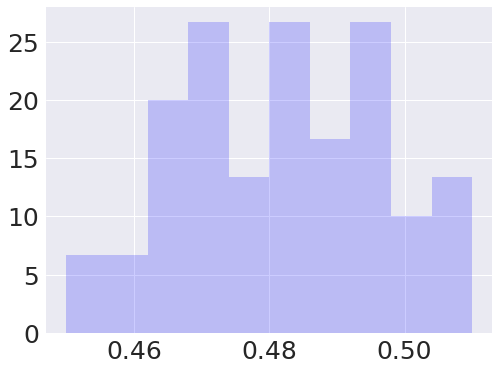

In [67]:
plt.hist(big_list[0], color='blue', density=True, stacked=True, alpha=0.2)

####  A complete examples in one function

In [142]:
%%time
ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0
minicolumns = 5
hypercolumns = 1
T_persistence = 0.050

sigma50, result = find_p50(ws, wn, wb, alpha, minicolumns, hypercolumns, T_persistence,
                           n_samples=100, deep=10, verbose=True)
print('sigma50', sigma50, 'result', result)

bounds 4.0 6.0
result 0.64
bounds 5.0 6.0
result 0.44
bounds 5.0 5.5
result 0.57
bounds 5.25 5.5
result 0.44
bounds 5.25 5.375
result 0.48
bounds 5.25 5.3125
result 0.55
bounds 5.28125 5.3125
result 0.57
bounds 5.296875 5.3125
result 0.57
bounds 5.3046875 5.3125
result 0.48
bounds 5.3046875 5.30859375
result 0.58
bounds 5.306640625 5.30859375
result 0.54
bounds 5.3076171875 5.30859375
result 0.59
bounds 5.30810546875 5.30859375
result 0.49
bounds 5.30810546875 5.308349609375
result 0.55
bounds 5.3082275390625 5.308349609375
result 0.58
bounds 5.30828857421875 5.308349609375
CPU times: user 41.7 s, sys: 16 ms, total: 41.7 s
Wall time: 41.8 s


## Systematic probability

### Alpha

In [151]:
%%time
alpha_num = 15
alpha_vector = np.linspace(0.5, 25, num=alpha_num)
sigma05_vector = np.zeros(alpha_num)
p05_vector = np.zeros(alpha_num)


ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0
minicolumns = 5
hypercolumns = 1
T_persistence = 0.050
n_samples = 100
deep = 10

for index, alpha in enumerate(alpha_vector):
    print(alpha)
    sigma05, p05 = find_p50(ws, wn, wb, alpha, minicolumns, hypercolumns, T_persistence, 
                            n_samples=n_samples, deep=deep, verbose=False)
    print('--------')
    sigma05_vector[index] = sigma05
    p05_vector[index] = p05

0.5
--------
2.25
--------
4.0
--------
5.75
--------
7.5
--------
9.25
--------
11.0
--------
12.75
--------
14.5
--------
16.25
--------
18.0
--------
19.75
--------
21.5
--------
23.25
--------
25.0
--------
CPU times: user 11min 33s, sys: 452 ms, total: 11min 33s
Wall time: 11min 34s


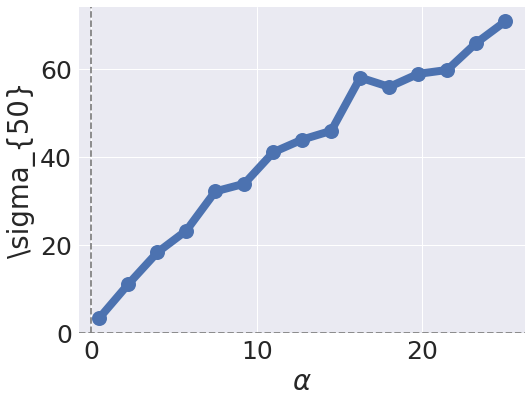

In [152]:
lw = 8
ms = 15

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alpha_vector, sigma05_vector, 'o-', lw=lw, ms=ms)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\sigma_{50}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

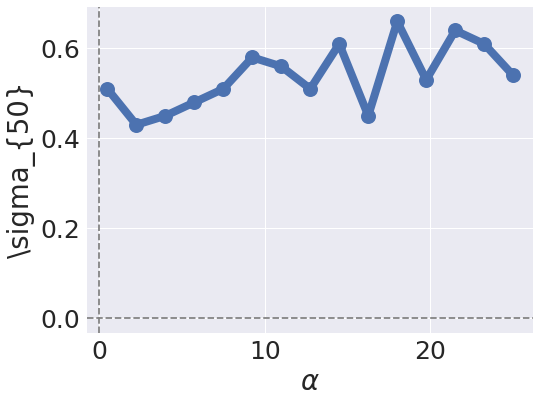

In [153]:
lw = 8
ms = 15

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alpha_vector, p05_vector, 'o-', lw=lw, ms=ms)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$p_{50}$')

ax.set_ylim([0.0, 1.0])
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

### Ws

In [173]:
%%time
ws_num = 8
ws_vector = np.linspace(1, 30, num=ws_num )
sigma05_vector_ws = np.zeros(ws_num)
p05_vector_ws = np.zeros(ws_num)


ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0
minicolumns = 5
hypercolumns = 1
T_persistence = 0.050
n_samples = 100
deep = 10

for index, ws in enumerate(ws_vector):
    print(ws)
    sigma05, p05 = find_p50(ws, wn, wb, alpha, minicolumns, hypercolumns, T_persistence, 
                            n_samples=n_samples, deep=deep, verbose=False)
    print('--------')
    sigma05_vector_ws[index] = sigma05
    p05_vector_ws[index] = p05

1.0
--------
5.142857142857143
--------
9.285714285714286
--------
13.42857142857143
--------
17.571428571428573
--------
21.714285714285715
--------
25.85714285714286
--------
30.0
--------
CPU times: user 3min 53s, sys: 84 ms, total: 3min 53s
Wall time: 3min 54s


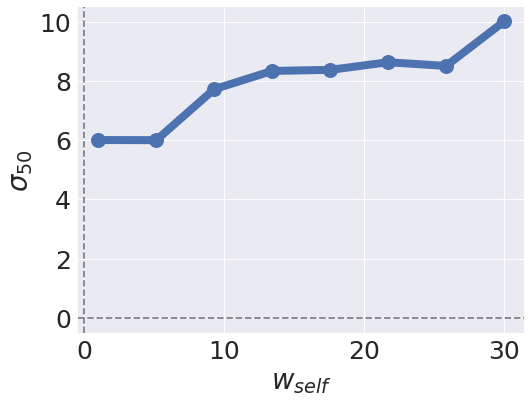

In [174]:
lw = 8
ms = 15

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ws_vector, sigma05_vector_ws, 'o-', lw=lw, ms=ms)

ax.set_xlabel(r'$w_{self}$')
ax.set_ylabel(r'$\sigma_{50}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

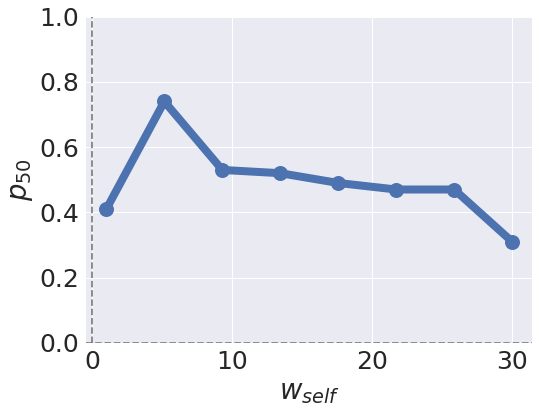

In [176]:
lw = 8
ms = 15

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ws_vector, p05_vector_ws, 'o-', lw=lw, ms=ms)

ax.set_xlabel(r'$w_{self}$')
ax.set_ylabel(r'$p_{50}$')
ax.set_ylim([0.0, 1.0])
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

### Minicolumns

In [166]:
%%time
ws_num = 10
minicolumns_vector = np.arange(5, 25, 5).astype('int')
minicolumns_num = minicolumns_vector.size
sigma05_vector_minicolumns = np.zeros(minicolumns_num)
p05_vector_minicolumns = np.zeros(minicolumns_num)


ws = 1.0
wn = 0.0
wb = -20.0
alpha = 1.0
minicolumns = 5
hypercolumns = 1
T_persistence = 0.050
n_samples = 100
deep = 10

for index, minicolumns in enumerate(minicolumns_vector):
    print(minicolumns)
    sigma05, p05 = find_p50(ws, wn, wb, alpha, minicolumns, hypercolumns, T_persistence, 
                            n_samples=n_samples, deep=deep, verbose=False)
    print('--------')
    sigma05_vector_minicolumns[index] = sigma05
    p05_vector_minicolumns[index] = p05

5
--------
10
--------
15
--------
20
--------
CPU times: user 9min 12s, sys: 316 ms, total: 9min 12s
Wall time: 9min 13s


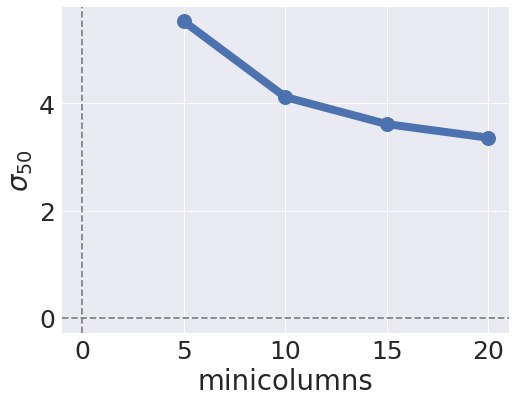

In [167]:
lw = 8
ms = 15

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(minicolumns_vector, sigma05_vector_minicolumns, 'o-', lw=lw, ms=ms)

ax.set_xlabel('minicolumns')
ax.set_ylabel(r'$\sigma_{50}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

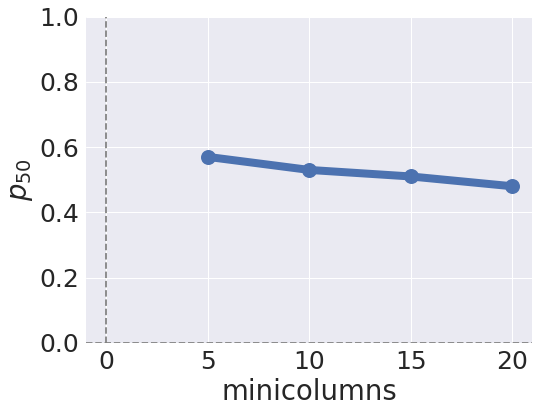

In [169]:
lw = 8
ms = 15

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(minicolumns_vector, p05_vector_minicolumns, 'o-', lw=lw, ms=ms)

ax.set_xlabel('minicolumns')
ax.set_ylabel(r'$p_{50}$')


ax.set_ylim([0.0, 1.0])
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');